<a href="https://colab.research.google.com/github/Lampyriss/Lampyriss/blob/main/ShipObjectDetectionPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIForYou

6530200151  นายณัฐพริษฐ์ สมบูรณ์  

6530200673  นายนนทวัฒน์ พันธ์เผือก  

6530200819  นายสถาพร สัตยชิติ  

6530200304  นายพีระเมศร์ จุกกษัตริย์

6530200266  นายปรวภัทร มุธะรพัฒน์  


Model Part 1 Reference from : https://www.kaggle.com/code/apollo2506/ship-detection-using-faster-r-cnn-part-1

Model Part 2 Reference from : https://www.kaggle.com/code/apollo2506/ship-detection-using-faster-r-cnn-part-2

In [ ]:
# !pip uninstall opencv-python-headless
# !pip uninstall opencv-contrib-python-headless
#!pip uninstall -y opencv-python

In [ ]:
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
!pip install opencv-python
!pip3 install opencv-contrib-python
!pip3 install imutils

In [ ]:
import numpy as np
import pandas as pd
import cv2, os, re
import matplotlib.pyplot as plt
import imutils

from tqdm import tqdm
from imutils.object_detection import non_max_suppression
from tensorflow.keras.models import load_model

In [ ]:
def find_regions(image, method):

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()

    rects = ss.process()
    boxes = []
    for (x,y,w,h) in rects:

        boxes.append([x,y,w,h])
        pass

    return boxes
    pass

ฟังก์ชัน find_regions ใช้เทคนิคการตรวจจับวัตถุแบบสร้างป้ายอัตโนมัติ (selective search) เพื่อค้นหาพื้นที่ที่เป็นไปได้ที่มีวัตถุในภาพที่กำหนด (image) โดยมีการใช้คลาส cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() เพื่อสร้างวัตถุในภาพ และกำหนดภาพฐานด้วย ss.setBaseImage(image) ซึ่งจะเป็นการตั้งค่าภาพที่จะนำไปใช้ใน selective search ต่อไป

หลังจากนั้นฟังก์ชันจะเลือกวิธีการของ selective search ตามที่กำหนดในพารามิเตอร์ method ซึ่งสามารถเป็น 'fast' หรือวิธีการอื่น ๆ ที่กำหนดไว้ในฟังก์ชัน และทำการประมวลผล selective search เพื่อค้นหาพื้นที่ที่พบวัตถุ ซึ่งจะถูกจัดเก็บไว้ในรายการ boxes ซึ่งจะถูกส่งคืนเป็นผลลัพธ์ของฟังก์ชัน

ในส่วนท้ายของฟังก์ชัน จะมีการส่งคืนรายการของพิกัดของสี่เหลี่ยมที่พบวัตถุในภาพออกไปให้กับโปรแกรมที่เรียกใช้งาน

In [ ]:
scene_path = '/content/drive/MyDrive/AI/scenes/scenes'

def load_scenes():

    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    for file in dirfiles:

        print(os.path.join(scene_path, file))
        scene = cv2.imread(os.path.join(scene_path, file))
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scenes.append(scene)
        pass

    return scenes
    pass

โค้ดด้านบนเป็นฟังก์ชัน `load_scenes` ที่ใช้ในการโหลดภาพจากโฟลเดอร์ที่กำหนดไว้ใน `scene_path` และนำมาเก็บไว้ในรายการ `scenes` โดยดำเนินการดังนี้:

1. สร้างรายการ `scenes` เปล่าขึ้นมา
2. ดึงรายชื่อของไฟล์ทั้งหมดในโฟลเดอร์ `scene_path` และเรียงลำดับตามตัวอักษร
3. วนลูปผ่านรายชื่อของไฟล์แต่ละตัว
    - โหลดภาพด้วย OpenCV (`cv2.imread`)
    - แปลงภาพให้อยู่ในรูปแบบของสี RGB โดยใช้ `cv2.cvtColor`
    - เพิ่มภาพลงในรายการ `scenes`
4. ส่งคืนรายการ `scenes` ที่มีภาพทั้งหมดที่โหลดมา

In [ ]:
scenes = load_scenes()

/content/drive/MyDrive/AI/scenes/scenes/sfbay_1.png
/content/drive/MyDrive/AI/scenes/scenes/sfbay_2.png


โค้ด `scenes = load_scenes()` โหลดรูปภาพจากโฟลเดอร์ที่ระบุไว้ใน `scene_path` และเก็บภาพในตัวแปร `scenes` เพื่อใช้งานต่อไปได้ โดยการทำงานของฟังก์ชัน `load_scenes()` คือ:

1. สร้างรายการเปล่าสำหรับเก็บรูปภาพที่โหลด
2. ดึงรายชื่อของไฟล์ทั้งหมดในโฟลเดอร์ที่กำหนด
3. โหลดและแปลงภาพในรูปแบบ RGB จากที่ได้รับมา
4. เพิ่มรูปภาพลงในรายการ
5. ส่งคืนรายการรูปภาพทั้งหมดที่โหลดมาในฟังก์ชัน

ดังนั้นตัวแปร `scenes` จะมีรูปภาพทั้งหมดที่โหลดมาจากโฟลเดอร์ที่กำหนดไว้ใน `scene_path` ที่ใช้ในการประมวลผลต่อไปได้

In [ ]:
%%time
method = "fast"

boxes = []

for scene in scenes:

    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

CPU times: user 43.3 s, sys: 3.33 s, total: 46.6 s
Wall time: 46.1 s


โค้ดด้านบนใช้วิธีการ selective search เพื่อค้นหาพื้นที่ที่พบวัตถุในภาพทั้งหมดที่โหลดมา โดยใช้วิธีการ fast selective search และเก็บพื้นที่ที่พบวัตถุลงในรายการ boxes สำหรับแต่ละภาพใน scenes โดยใช้วิธีการ fast selective search และส่งคืนรายการ boxes ที่พบในแต่ละภาพ

In [ ]:
model = load_model('/content/drive/MyDrive/AI/model_weights.h5')

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d_3 (ZeroPadd  (None, 58, 58, 3)         0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 29, 29, 16)        64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 29, 2

In [ ]:
%%time

rois, locs = [], []
images = []
labels = []
for i, scene in tqdm(enumerate(scenes)):
    (H, W) = scene.shape[:2]
    region, loc = [], []
    for (x, y, w, h) in boxes[i]:
        if w / float(W) > 0.10 and h / float(H) > 0.10:
            continue
        roi = scene[y:y+h, x:x+w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (48, 48))
        rois.append(roi)
        locs.append((x, y, x+w, y+h))
        pass

    preds = model.predict(np.array(rois, dtype=np.float32))
    preds = np.argmax(preds, axis=1)

    img = scene.copy()
    for j, label in enumerate(preds):
        if label == 1:
            (startX, startY, endX, endY) = locs[j]
            cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
            cv2.putText(img, 'Ship', (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
        elif label != 1:  # ไม่ต้องเสดงป้ายกำกับเมื่อไม่ใช่เรือ
            pass

    images.append(img)
    del rois[:]
    del locs[:]
    pass



0it [00:00, ?it/s]

10/10 [==============================] - 0s 17ms/step


1it [00:00,  1.74it/s]

6/6 [==============================] - 0s 27ms/step


2it [00:00,  2.06it/s]

CPU times: user 810 ms, sys: 7.85 ms, total: 818 ms
Wall time: 985 ms


โค้ดด้านบนทำการประมวลผลทุกภาพใน `scenes` โดยดำเนินการดังนี้:

1. วนลูปผ่านทุกภาพใน `scenes` โดยใช้ `tqdm` เพื่อแสดงแถบความคืบหน้า
2. สร้างตัวแปร `H` และ `W` เพื่อเก็บความสูงและความกว้างของภาพ
3. วนลูปผ่านพื้นที่ที่พบวัตถุในแต่ละภาพ (ที่ถูกเก็บไว้ใน `boxes[i]`)
   - ตรวจสอบว่าขนาดของพื้นที่ที่พบวัตถุมีขนาดเล็กกว่า 10% ของความสูงหรือความกว้างของภาพหรือไม่ ถ้าใช่ก็ข้ามขั้นตอนนี้
   - คัดลอกพื้นที่ที่พบวัตถุ (ROI) จากภาพเพื่อนำมาใช้ในการทำนาย
   - เพิ่ม ROI และพื้นที่ที่พบวัตถุ (ในรูปแบบของ bounding box) เข้าไปในรายการ `rois` และ `locs` ตามลำดับ
4. ทำการทำนายบน ROIs โดยใช้โมเดล
5. สร้างภาพที่มีการวาดกรอบรอบพื้นที่ที่พบวัตถุบนภาพด้วย OpenCV
6. เพิ่มภาพที่ผ่านการประมวลผลลงในรายการ `images`

โดยสรุปคือโค้ดนี้ทำการตรวจจับวัตถุในแต่ละภาพที่โหลดมา และสร้างภาพที่มีการวาดกรอบรอบวัตถุที่ตรวจจับได้ เพื่อให้เห็นการตรวจจับวัตถุบนภาพได้ชัดเจน

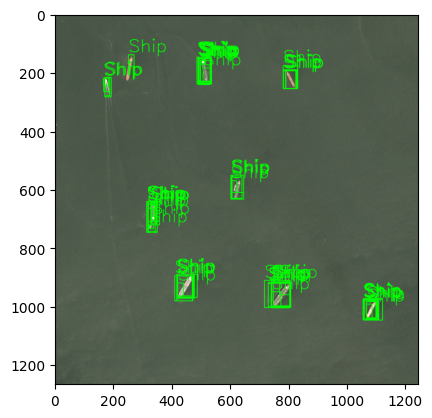

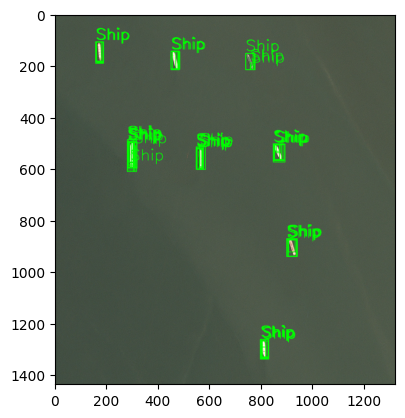

In [ ]:
for image in images:

    plt.imshow(image)
    plt.show();

โค้ดนี้ใช้วนลูปผ่านภาพที่ผ่านการประมวลผลแล้ว (ภาพที่มีกรอบรอบวัตถุที่ตรวจจับได้) และแสดงภาพในหน้าต่างกราฟิกโดยใช้ `plt.imshow(image)` และ `plt.show()` โดยทำให้สามารถดูภาพที่ผ่านการประมวลผลแล้วได้แบบต่อเนื่องโดยไม่ต้องเปิดภาพเข้ามาดูทีละภาพในโปรแกรมต่างๆ โดยใช้งานไลบรารี `matplotlib.pyplot`